# **自然言語・可視化・分析ライブラリ**
Word Cloud、nlplot（頻出ワードグラフや共起ネットワーク等の可視化や分析）、TF-IDF計算、word2vecによるワードのベクトル計算と可視化（PCAとt-SNE）を実行します。\
分析したい文書（テキストファイル）を読み込み、「ランタイム→すべてのセルを実行」するだけです。\
前処理（改行, 空白等の処理）→形態素分析→各種視覚化は自動で行います。
- [**注意**] テキストファイルは文字コードを「UTF-8」としてください。

# **ライブラリのインストール**

In [ ]:
pip install nlplot

     |████████████████████████████████| 967 kB 5.2 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
#日本語フォントをインストール
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 2s (5,067 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-18ubuntu1) ...
Selecting previously unselected package fonts-ip

In [ ]:
#Mecabのインストール
!pip install mecab-python3==0.996.5

     |████████████████████████████████| 17.1 MB 4.7 MB/s 


In [ ]:
#matplotlib日本語化
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=3e4f2baea23aee2c977be3364a3d9476b94ce23cf449f25c8bce9119c05e7690
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
from pathlib import Path
import pandas as pd
import re
import MeCab
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# **ファイル & ストップワード指定**

In [ ]:
#@title txtファイル（UTF-8）を指定してください
from google.colab import files
#print('txtファイル(UTF-8）を指定してください')
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving cs_voc.txt to cs_voc.txt
User uploaded file "cs_voc.txt" with length 37398 bytes


In [ ]:
#@title ストップワード設定
stop_words = ["し", "い", "ある", "おる", "せる", "ない", "いる", "する", "の", "よう", "なる", "それ", "そこ", "これ", "こう", "ため", "そう", "れる", "られる"]

# **モジュール構築**
- 前処理（改行や空白の処理、センテンス化）、形態素分析、ワード出現回数処理を実行
- 文章を語に分解後、一般名詞・動詞・形容詞（動詞と形容詞は基礎型）のみ抽出（※追加や変更はコード操作が必要）


In [ ]:
#@title テキストデータ前処理＆センテンス化
if len(uploaded.keys()) != 1:
    print("アップロードは１ファイルにのみ限ります")
else:
    target = list(uploaded.keys())[0]

with open(target, 'r', encoding='utf-8') as file:
    lines = file.readlines()

#with open(filename, 'r', encoding='utf-8') as file:
#    lines = file.readlines()

lines = [l.strip() for l in lines]
lines = [l.replace('\t','') for l in lines]
lines = [l.replace('"','') for l in lines]
lines = [l.strip('（') for l in lines]
lines = [l.strip('）') for l in lines]

sentences = []
for sentence in lines:
    texts = sentence.split('。')
    sentences.extend(texts)

In [ ]:
#@title 前処理後の全文書表示
with open(target, 'r', encoding='utf-8') as all:
    all_text = all.readlines()

#with open(filename, 'r', encoding='utf-8') as all:
#    all_text = all.readlines()

all_text = [l.strip() for l in all_text]
all_text = [l.replace('\t','') for l in lines]
all_text = [l.replace('"','') for l in lines]
all_text = [l.strip('（') for l in lines]
all_text = [l.strip('）') for l in lines]

all_text = ''.join(all_text)
all_text

'単価が高いので特にありません。内勤なので正直よくわからないのでいいえを選択させていただきました。顧客からの要望がない為。（こちらからは提案している。）現在のところは特段要望はない。天井センサーの検知エリアをオプションのプリズムを使わなくても良い、より広範囲な製品があるとうれしいです。客先からの要望が無い為比較的満足です。低高さに設置して広範囲をｶﾊﾞｰ出来るｾﾝｻｰがあれば助かります。W5000×H3000を1個のｾﾝｻｰでｶﾊﾞｰ出来るぐらい。上記のアンケート結果は光電センサについてです。尚、弊社のシャッター製品では、御社の無目センサはあまり使用していませんが、現場からの声としましては、竹中Ｅ社の製品を含めて感度やノイズ除去などの諸設定が難解であり、現場に最適な設定ができない（わからない）とのことです。私見ですが、難解の原因はセンサの取説がわかりにくことです。（御社で技術関係以外の方が読んでも理解できないと思います）無目センサの取付に慣れている人が読めばなんのとなく理解できる内容であり、慣れていない人はほとんど理解できません。家電の取説のように用語説明･設定の意図･設定の具体例などをイラストを加えて記載した方が良いです。環境（雨・日差し・雪・汚れ等）に影響されず、赤外線式に負けない安価なセンサーをご提案願います。配線がオプションなのと、何が必要な配線なのかがイマイチ分かりずらい。特にありません。1000mmぐらい飛ぶ手かざし用のセンサー側あるといいかもしれません特にありません。特にありません。220のセンサーエリアが広すぎる。もう少し細かい範囲調整が出来る様にして欲しい。天井センサーをナブコさんのようにすっきりしたデザインにして欲しい。VVS\u3000カメラ別体にして無目に内蔵できるサイズにして欲しい。特にありません。各センサーの検出エリアのチェックシートが欲しいです。ビルトインセンサーの検出エリアを左右振り出来るようにして欲しいです。タッチスイッチ（子機）に防水対応の表記をして欲しいです。無目内蔵型センサーでＯＡ２３１ビルトインをＣＡＮ対応にして欲しいです。衝突防止センサーとして戸袋にビルトインや天井センサーを取り付けることが多いのでセンサーエリアの消去をより細かく設定できるようにして欲しいです。・OATなど４芯と２芯をセンサー内に収める際、線の長さや取り回

In [ ]:
#@title センテンスをデータフレームに格納
import pandas as pd
import numpy as np

df_text = pd.DataFrame(sentences, columns = ['text'], index=None)

#空白をNaNに置き換え
df_text['text'].replace('', np.nan, inplace=True)

#Nanを削除 inplace=Trueでdf上書き
df_text.dropna(subset=['text'], inplace=True)

df_text[:15]

,text
0,単価が高いので特にありません
2,内勤なので正直よくわからないのでいいえを選択させていただきました
4,顧客からの要望がない為
5,（こちらからは提案している
6,）現在のところは特段要望はない
9,天井センサーの検知エリアをオプションのプリズムを使わなくても良い、より広範囲な製品があるとう...
10,客先からの要望が無い為
12,比較的満足です
13,低高さに設置して広範囲をｶﾊﾞｰ出来るｾﾝｻｰがあれば助かります
14,W5000×H3000を1個のｾﾝｻｰでｶﾊﾞｰ出来るぐらい


In [ ]:
#@title 形態素解析（一般名詞・動詞:基礎型・形容詞:基礎型）＆カンマ･スペース区切りをデータフレームに格納
#スペース区切り分かち書き
def mecab_analysis(text):

    t = MeCab.Tagger('-Ochasen')

    node = t.parseToNode(text)

    words = []
     
    while node:
        if node.surface != "":  # ヘッダとフッタを除外

            word_type = node.feature.split(',')[0]
            sub_type = node.feature.split(',')[1]
            features_ = node.feature.split(',')

            #品詞を選択
            if word_type in ["名詞"]: 
                if sub_type in ['一般']:
                    word = node.surface
                    words.append(word)

            #動詞、形容詞[基礎型]を抽出（名詞のみを抽出したい場合は以下コードを除く）
            elif word_type in ['動詞','形容詞'] and not (features_[6] in stop_words):
                words.append(features_[6])

        node = node.next

        if node is None:
            break

    return " ".join(words)

#カンマ区切り分かち書き
def mecab_analysis2(text):

    t = MeCab.Tagger('-Ochasen')

    node = t.parseToNode(text)

    words2 = []

    while(node):

        if node.surface != "":  # ヘッダとフッタを除外
            word_type = node.feature.split(',')[0]
            sub_type = node.feature.split(',')[1]
            features_ = node.feature.split(',')

            if word_type in ['名詞']:  # 名詞をリストに追加する
                if sub_type in ['一般']:
                    words2.append(node.surface)

            #動詞、形容詞[基礎型]を抽出（名詞のみを抽出したい場合は以下コードを除く）
            elif word_type in ['動詞','形容詞'] and not (features_[6] in stop_words):
                    words2.append(features_[6])

        node = node.next
        if node is None:
            break
    return words2

#スペース区切り分かち書き（全文書一括）
def mecab_analysis3(text):

    t = MeCab.Tagger('-Ochasen')

    node = t.parseToNode(all_text)

    words3 = []
     
    while node:
        if node.surface != "":  # ヘッダとフッタを除外

            word_type = node.feature.split(',')[0]
            sub_type = node.feature.split(',')[1]
            features_ = node.feature.split(',')

            #品詞を選択
            if word_type in ["名詞"]: 
                if sub_type in ['一般']:
                    all_text_word = node.surface
                    words3.append(all_text_word)

            #動詞、形容詞[基礎型]を抽出（名詞のみを抽出したい場合は以下コードを除く）
            elif word_type in ['動詞','形容詞'] and not (features_[6] in stop_words):
                words3.append(features_[6])

        node = node.next

        if node is None:
            break

    return " ".join(words3)

#形態素結果をリスト化し、データフレームdf_textに列を追加して格納
df_text['words'] = df_text['text'].apply(mecab_analysis)
df_text['words2'] = df_text['text'].apply(mecab_analysis2)

df_text[:15]

,text,words,words2
0,単価が高いので特にありません,単価 高い,"[単価, 高い]"
2,内勤なので正直よくわからないのでいいえを選択させていただきました,わかる いただく,"[わかる, いただく]"
4,顧客からの要望がない為,顧客,[顧客]
5,（こちらからは提案している,,[]
6,）現在のところは特段要望はない,特段,[特段]
9,天井センサーの検知エリアをオプションのプリズムを使わなくても良い、より広範囲な製品があるとう...,天井 センサー エリア オプション プリズム 使う 良い 製品 うれしい,"[天井, センサー, エリア, オプション, プリズム, 使う, 良い, 製品, うれしい]"
10,客先からの要望が無い為,客 無い,"[客, 無い]"
12,比較的満足です,,[]
13,低高さに設置して広範囲をｶﾊﾞｰ出来るｾﾝｻｰがあれば助かります,高い 広範囲 ｶﾊﾞｰ 出来る ｾﾝｻｰ 助かる,"[高い, 広範囲, ｶﾊﾞｰ, 出来る, ｾﾝｻｰ, 助かる]"
14,W5000×H3000を1個のｾﾝｻｰでｶﾊﾞｰ出来るぐらい,W ×H ｾﾝｻｰ ｶﾊﾞｰ 出来る,"[W, ×H, ｾﾝｻｰ, ｶﾊﾞｰ, 出来る]"


In [ ]:
#@title 全文書の形態素結果をデータフレームdfに格納
df = pd.Series(all_text)
df = df.apply(mecab_analysis3)

In [ ]:
#@title ワード出現回数カウント（表示する場合は#外す）
#カンマ区切り分かち書きしたワードをリスト化
words_list = df_text.words2.tolist()
words_list = sum(words_list,[])

from collections import Counter

#出現回数を集計し、最頻順にソートし、resultに格納
words_count = Counter(words_list)
result = words_count.most_common()

#出現回数結果を画面に出力
#for word, cnt in result:
#    print(word, cnt)

# **Word Cloud**
- ワードクラウドは、文章中で出現頻度が高い語を複数選び出し、その頻度に応じた大きさで図示する手法。

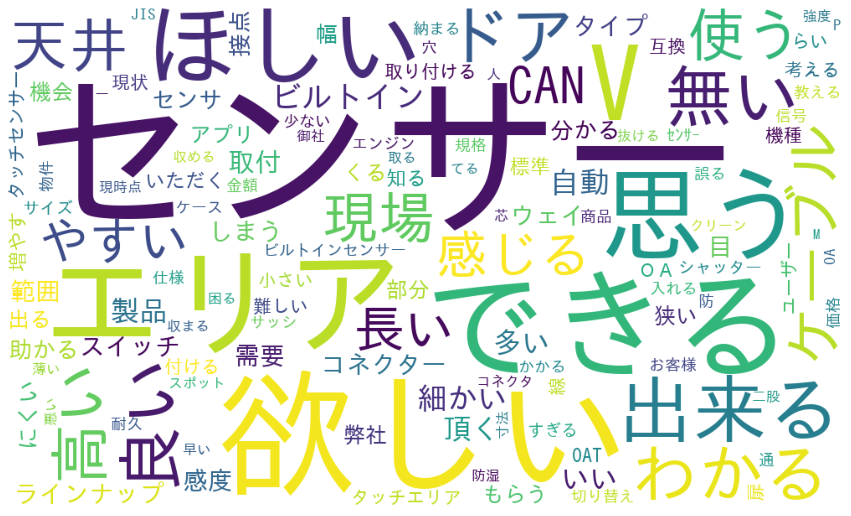

In [ ]:
#@title Word Cloud（🔲型）表示
#wordcloud取込用にresultを辞書型ヘ変換
dic_result = dict(result)

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1000,
                      height=600,
                      ).fit_words(dic_result)

#生成した画像の表示
import matplotlib.pyplot as plt 
from matplotlib import rcParams

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

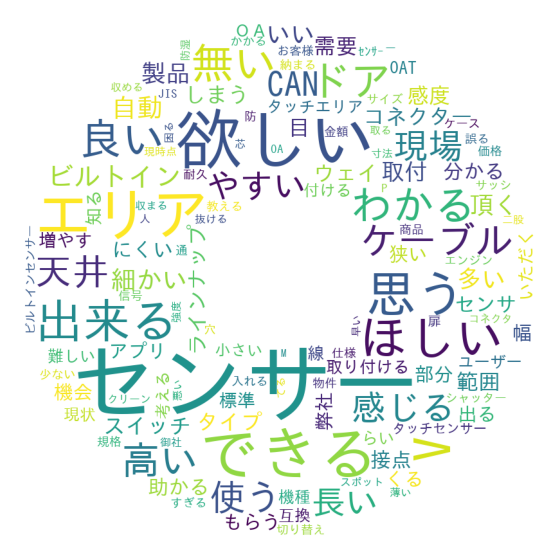

In [ ]:
#@title Word Cloud（🍩型）表示
#画像データダウンロード（biwakoの画像リンクもあり。変更する場合は#調整）
import requests

url = "https://github.com/hima2b4/Word-Cloud/raw/main/donuts.png"
#url = "https://github.com/hima2b4/Word-Cloud/raw/main/biwa.png"

file_name = "donuts.png"
#file_name = "biwa.png"

response = requests.get(url)
image = response.content

with open(file_name, "wb") as f:
    f.write(image)

#ライブラリインポート
from PIL import Image
import numpy as np

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
custom_mask = np.array(Image.open('donuts.png'))
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      mask=custom_mask,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1200,
                      height=1200
                      ).fit_words(dic_result)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **nlplot**
「nlplot」は、自然言語の可視化・分析できるライブラリです。
- N-gram bar chart, N-gram tree Map, Histogram of the word count, wordcloud, co-occurrence networks（共起ネットワーク）, sunburst chart（サンバースト）

In [ ]:
#@title uni-gram表示
import nlplot

npt = nlplot.NLPlot(df_text, target_col='words')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
#stopwords = npt.get_stopword(top_n=0, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
#    stopwords=stopwords,
)

100%|██████████| 420/420 [00:00<00:00, 156754.55it/s]


In [ ]:
#@title tree-map表示
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
#    stopwords=stopwords,
)

100%|██████████| 420/420 [00:00<00:00, 96257.45it/s]


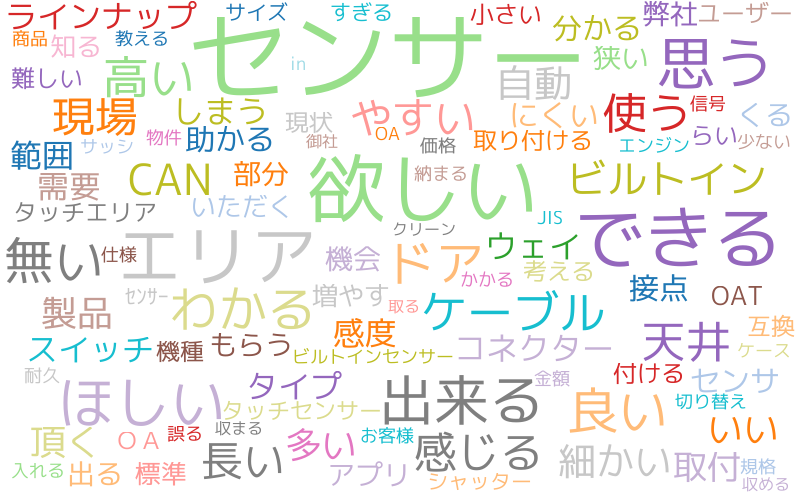

In [ ]:
#@title Word Cloud表示（nlpot）
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
#    stopwords=stopwords,
)

In [ ]:
#@title Word Distribution表示（単語数の分布）
npt.word_distribution(
    title='number of words distribution',
    xaxis_label='count',
)

In [ ]:
#@title Build Graph（共起ネットワーク）表示
# ビルド（データ件数によっては処理に時間を要します）※ノードの数のみ変更
npt.build_graph(min_edge_frequency=1,
                #stopwords=stopwords,
                )

display(
    npt.node_df.head(), npt.node_df.shape,
    npt.edge_df.head(), npt.edge_df.shape
)

npt.co_network(
    title='Co-occurrence network',
)

node_size:153, edge_size:378


,id,id_code,adjacency_frequency,betweeness_centrality,clustering_coefficient,community
0,需要,0,2,0.011764,0.000000,5
1,出る,1,4,0.000135,0.666667,4
2,コロナ,2,1,0.000000,0.000000,3
3,良い,3,9,0.012602,0.611111,2
4,値段,4,1,0.000000,0.000000,8


(153, 6)

,source,target,edge_frequency,source_code,target_code
0,センサー,欲しい,22,149,108
1,センサー,天井,14,149,53
2,エリア,センサー,13,34,149
3,できる,エリア,11,69,34
4,センサー,長い,10,149,107


(378, 5)

In [ ]:
#@title Sunburst表示
npt.sunburst(
    title='All sentiment sunburst chart',
    colorscale=True,
    color_continuous_scale='Oryel',
    width=800,
    height=600,
    #save=True
)

# **TF-IDF**
TF-IDF は ワードの出現頻度とレア度が考慮された指標

\begin{eqnarray} TF(d,w) &=& \frac{文書d における語wの出現回数}{文書d における全語の出現回数の和}\\ IDF(w) &=& log(\frac{全文書数}{語w を含む文書数})\\ TFIDF(d,w) &=& TF(d,w) \times IDF(w) \end{eqnarray}

- センテンス毎にTF-IDFを算出、センテンス×wordマトリクスをcsv出力(tfidf.csv)
- 文書全体でTF-IDFを算出したWord cloudを描画
- [**参考**] 指定センテンスのWord cloud描画も可能（Defaultは非表示、センテンスは任意指定）

In [ ]:
#@title TF-IDFマトリクス作成＆データフレーム格納
# ライブラリインポート
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDFのベクトル処理
vectorizer = TfidfVectorizer(use_idf=True)
tfidf = vectorizer.fit_transform(df_text['words'])

# TF-IDF値を「センテンス×ワード」マトリクスをデータフレーム化
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names(), index=df_text['words'])
display(df_tfidf)

,and,built,can,etc,fl,in,jis,led,mm,oa,oah,oat,off,pr,sus,vbuilt,vcan,あげる,あやしい,ありがたい,いい,いう,いく,いける,いただく,いただける,いた事,いれる,うすい,うまい,うれしい,おす,お客様,かかる,かさばる,かざし,かんがえる,かんじる,がれ,きく,...,開ける,開口,間違う,防湿,降雪,限る,離す,難しい,難点,電圧,需要,音声,頂く,頂ける,頻度,額面,願う,顧客,飛ぶ,首都,高い,高まる,高所,ｂｅａ,ｂｉ,ｂｏｘ,ｃａｎ,ｊｉｓｓ,ｏａ,ｏａｍ,ｐｈｐ,ｖｂｉ,ｴﾘｱ,ｶﾊﾞｰ,ｼﾞｬｯｸ,ｽﾀﾝﾀﾞｰﾄﾞ,ｾﾝｻｰ,ﾁﾗｯ,ﾊﾞｰｼﾞｮﾝｱｯﾌﾟ,ﾘﾓｺﾝ
words,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
単価 高い,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
わかる いただく,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.786802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
顧客,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
特段,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ドア ウェイ ムダ 開く,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ドア ウェイ やめる ムダ なくなる,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title TF-IDFマトリクスをcsv出力（ローカルファイルに出力する場合はfiles.downloadの#外す）
from google.colab import files
df_tfidf.to_csv('tfidf.csv',encoding='utf_8_sig')
#files.download('tfidf.csv') 

## **Word cloud with TF-IDF for All texts**

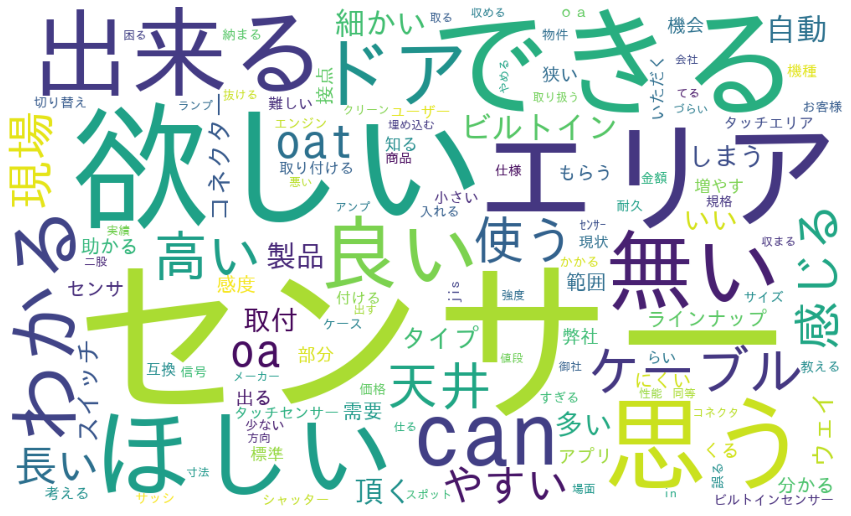

In [ ]:
#@title 全文書TF-IDF計算＆Word Cloud（TF-IDF）表示
# TF-IDF計算
tfidf_vec2 = vectorizer.fit_transform(df).toarray()[0]
# TF-IDFを辞書化
tfidf_dict2 = dict(zip(vectorizer.get_feature_names(), tfidf_vec2))
# 値が正のkeyだけ残す
tfidf_dict2 = {k: v for k, v in tfidf_dict2.items() if v > 0}

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1000,
                      height=600,
                      ).generate_from_frequencies(tfidf_dict2)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Word Cloud with TF-IDF for each Sentence**
※参考：このWord Cloudは指定センテンスの語のみを対象としたもの\
※表示する場合は #を外して実行\
※tfidf_vec = vectorizer.fit_transform(df_text['words']).toarray()[0] ←センテンスはこの数値で指定\
※語の表示数はmax_words, Word Cloudの表示サイズはwidth, heightで設定できる

In [ ]:
#@title 指定センテンスのTF-IDF計算＆Word Cloud表示
tfidf_vec = vectorizer.fit_transform(df_text['words']).toarray()[0]
# TF-IDFを辞書化
tfidf_dict = dict(zip(vectorizer.get_feature_names(), tfidf_vec))
# 値が正のkeyだけ残す
tfidf_dict = {k: v for k, v in tfidf_dict.items() if v > 0}

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=1000,
                      height=600,
                      ).generate_from_frequencies(tfidf_dict)

#生成した画像の表示
#plt.figure(figsize=(15,10))
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

# **Visualization of word2vec**

In [ ]:
#@title Word2Vecモジュール（語の最小出現数やベクトル生成手法等の設定）
from gensim.models import word2vec

# size : 中間層のニューロン数・数値に応じて配列の大きさが変わる。数値が多いほど精度が良くなりやすいが、処理が重くなる。
# min_count : この値以下の出現回数の単語を無視
# window : 対象単語を中心とした前後の単語数
# iter : epochs数
# sg : skip-gramを使うかどうか 0:CBOW 1:skip-gram

model = word2vec.Word2Vec(df_text['words2'],
                          size=200,
                          min_count=10,
                          window=5,
                          iter=20,
                          sg = 1)    # sg=1:skip-gram使用

#学習結果
#print(model.wv.vectors.shape)  # 分散表現の形状
#print(model.wv.vectors)  #分散表現の配列

In [ ]:
#@title ベクトル化した各語彙確認（表示する場合は#外す）
#ベクトル化したテキストの各語彙確認
#model.wv.index2word

<Figure size 432x288 with 0 Axes>

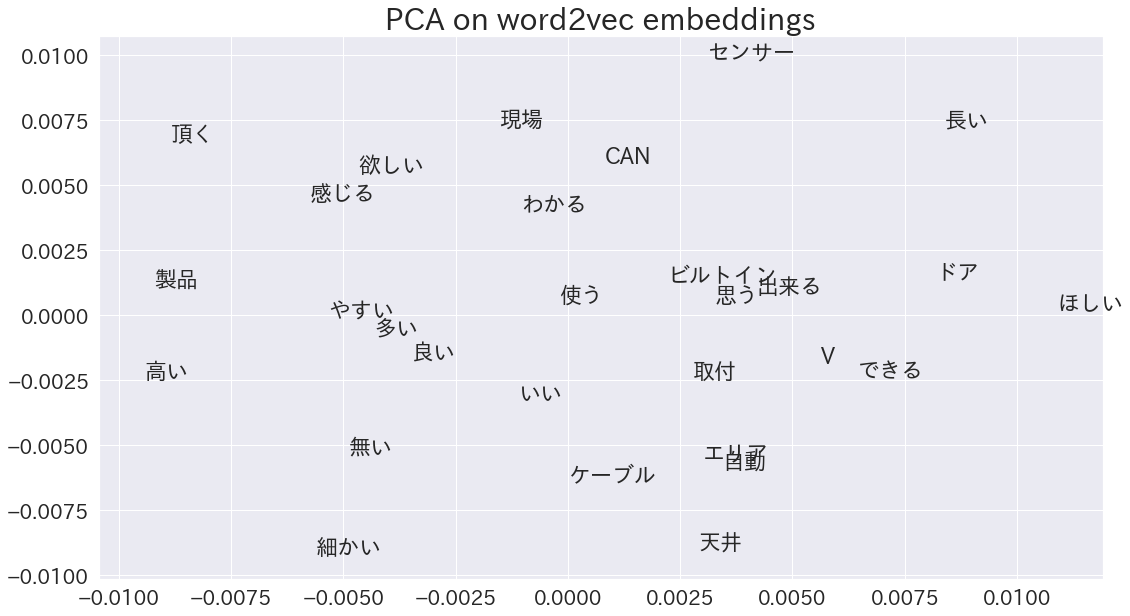

In [ ]:
#@title PCA表示
#PCA実行
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
values = pca.fit_transform(model.wv.vectors)
#print(values.shape)
#print(values)

#PCA可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 22
plt.tight_layout()
fig = plt.figure(figsize=(18,10))
for value, word in zip(values, model.wv.index2word):
    plt.plot(value[0], value[1], marker='')
    plt.annotate(word, (value[0], value[1]))
    plt.title('PCA on word2vec embeddings', fontsize=30)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
plt.show()

<Figure size 432x288 with 0 Axes>

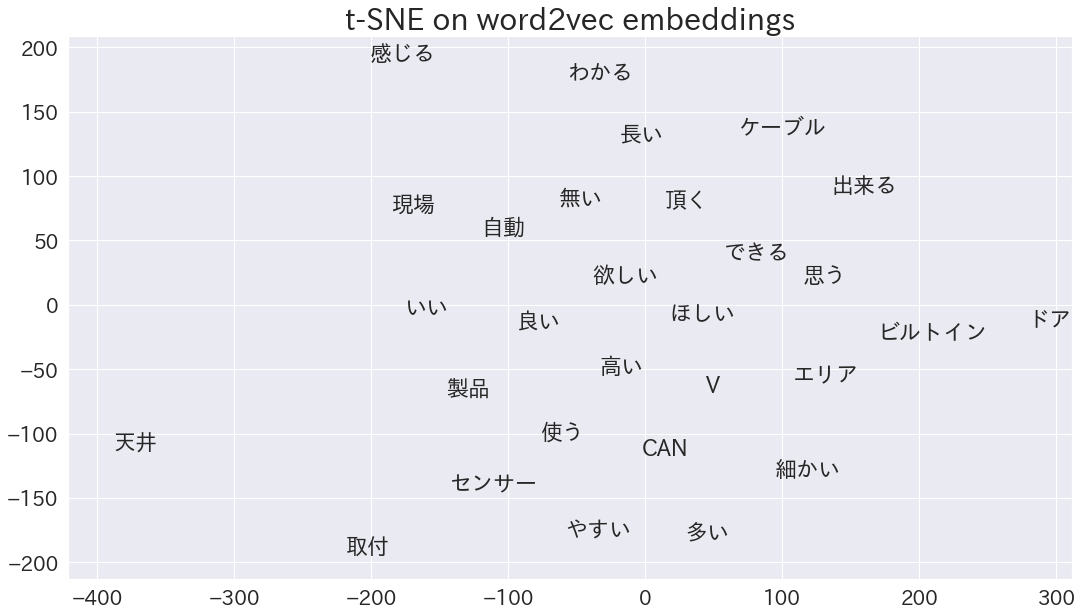

In [ ]:
#@title t-SNE表示
#t-SNE実行
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
values2 = tsne.fit_transform(model.wv.vectors)

#t-SNE可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 22
plt.tight_layout()
fig = plt.figure(figsize=(18,10))
for value, word in zip(values2, model.wv.index2word):
    plt.plot(value[0], value[1], marker='')
    plt.annotate(word, (value[0], value[1]))
    plt.title('t-SNE on word2vec embeddings', fontsize=30)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
plt.show()

## **参考サイト**
- [**【データ分析実践】口コミを使ったキャンプ場に関する分析3 ~ Word2Vec編 ~**](https://data-analytics.fun/2020/03/12/word2vec/)

- [**Janomeで TF-IDF をやってみた**](https://zenn.dev/megane_otoko/articles/013_tf_idf_trial)

- [**ニュース記事をword2vecでベクトル化して可視化するレシピ**](https://axross-recipe.com/recipes/34)

- [**自然言語を簡単に可視化・分析できるライブラリ「nlplot」を公開**](https://www.takapy.work/entry/2020/05/17/192947)